## KDTree and Spherical Clustering

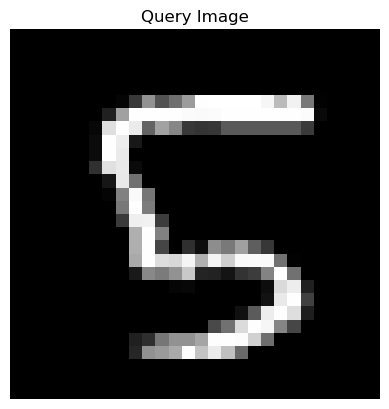

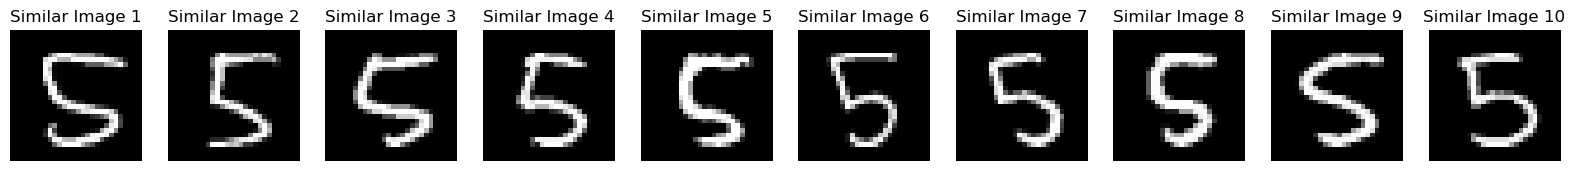

Query Image Label:  5
Similar Image 1 Label:  5
Similar Image 2 Label:  5
Similar Image 3 Label:  5
Similar Image 4 Label:  5
Similar Image 5 Label:  5
Similar Image 6 Label:  5
Similar Image 7 Label:  5
Similar Image 8 Label:  5
Similar Image 9 Label:  5
Similar Image 10 Label:  5
Search Precision is :: 1.0


In [31]:
from keras.datasets import mnist
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
from sklearn.metrics import precision_score


def PCAandKDTree(d,ls,kvalue): 
 (X_train, y_train), (X_test, y_test) = mnist.load_data()

 # Step 2: Reshape the data into 784*1 vector
 X_train = np.reshape(X_train, (X_train.shape[0], 784))
 X_test = np.reshape(X_test, (X_test.shape[0], 784))

 # Step 3: Apply PCA dimensionality reduction
 pca = PCA(n_components=d)
 X_train_pca = pca.fit_transform(X_train)

 # Construct a KD-Tree from the MNIST training data
 kdtree = KDTree(X_train_pca, leaf_size=ls)

 # Choose a random image from the test set
 query_image = X_test[np.random.randint(X_test.shape[0])]

 # Apply PCA dimensionality reduction to the query image
 query_image_pca = pca.transform(query_image.reshape(1, -1))

 # Perform a KD-Tree search for the 10 most similar images to the query image
 distances, indices = kdtree.query(query_image_pca, k=kvalue)

 # Get the corresponding labels for the similar images
 labels = y_train[indices[0]]
 import matplotlib.pyplot as plt
 
 plt.imshow(query_image.reshape(28, 28), cmap='gray')
 plt.title('Query Image')
 plt.axis('off')
 plt.show()
 
 fig, axes = plt.subplots(1, kvalue, figsize=(20, 2))

 for i, index in enumerate(indices[0]):
    axes[i].imshow(X_train[index].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Similar Image {i+1}')
    axes[i].axis('off')

 plt.show()
 print("Query Image Label: ", y_test[np.argwhere(np.all(X_test == query_image, axis=1))[0][0]])
 c = 0
 for i, index in enumerate(indices[0]):
     if ( y_test[np.argwhere(np.all(X_test == query_image, axis=1))[0][0]] ==  y_train[index]):
       c = c+1
     print(f"Similar Image {i+1} Label: ", y_train[index])

 print(f"Search Precision is :: {c/len(labels)}")

PCAandKDTree(100,30,10)

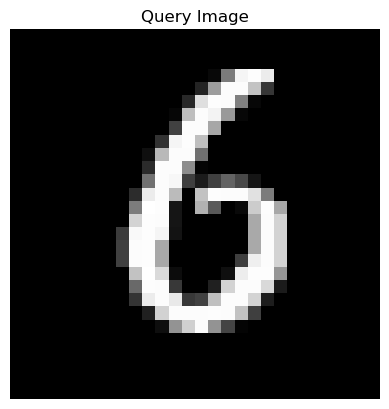

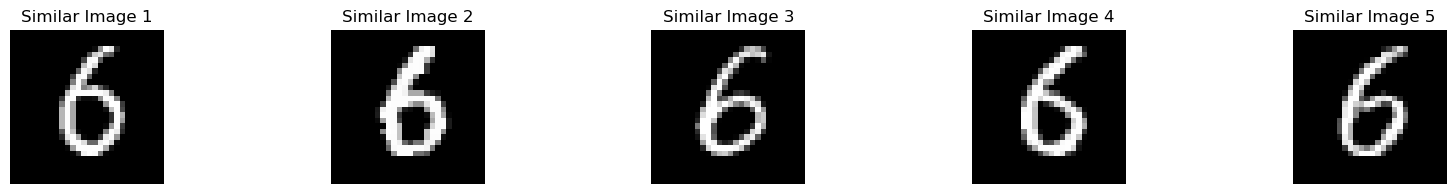

Query Image Label:  6
Similar Image 1 Label:  6
Similar Image 2 Label:  6
Similar Image 3 Label:  6
Similar Image 4 Label:  6
Similar Image 5 Label:  6
Search Precision is :: 1.0


In [32]:
PCAandKDTree(200,50,5)

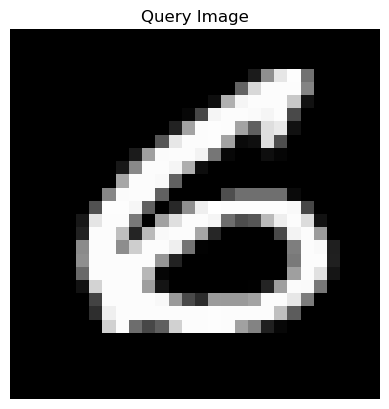

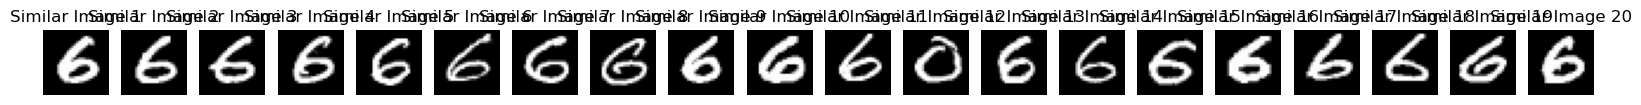

Query Image Label:  6
Similar Image 1 Label:  6
Similar Image 2 Label:  6
Similar Image 3 Label:  6
Similar Image 4 Label:  6
Similar Image 5 Label:  6
Similar Image 6 Label:  6
Similar Image 7 Label:  6
Similar Image 8 Label:  6
Similar Image 9 Label:  6
Similar Image 10 Label:  6
Similar Image 11 Label:  6
Similar Image 12 Label:  0
Similar Image 13 Label:  6
Similar Image 14 Label:  6
Similar Image 15 Label:  6
Similar Image 16 Label:  6
Similar Image 17 Label:  6
Similar Image 18 Label:  6
Similar Image 19 Label:  6
Similar Image 20 Label:  6
Search Precision is :: 0.95


In [35]:
PCAandKDTree(50,20,20)

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt

def pca(X, K):
    # center the data
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    # compute the covariance matrix
    cov = np.cov(X_centered.T)
    
    # compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    
    # sort the eigenvalues and eigenvectors in decreasing order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # select the top-K eigenvectors
    eigenvectors = eigenvectors[:, :K]
    
    # project the data onto the top-K eigenvectors
    X_proj = X_centered.dot(eigenvectors)
    
    return X_proj, eigenvectors, X_mean

# set the path to the faces dataset folder
path = r"C:\Users\PC\Desktop\Work\faces"

data = []
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # ignore non-directory files
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path)
                img = img.resize((64, 64))  # resize the images to 64x64
                img = np.array(img).flatten()  # flatten the images to 1D arrays
                data.append(img)
            except:
                print(f"Error loading file: {file_path}")

data = np.array(data)
n_samples = len(data)
n_features = data[0].size
data = data.reshape(n_samples, n_features)

# set aside 1 face per identity for testing
n_test = 15
test_idx = np.arange(n_test) * 11
test_data = data[test_idx]
train_data = np.delete(data, test_idx, axis=0)
n_train = train_data.shape[0]

# perform PCA on the training data
n_components = 50  # experiment with different values of K
train_proj, eigenvecs, X_mean = pca(train_data, n_components)

# visualize the top-K eigen faces
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    if i < n_components:
        ax.imshow(eigenvecs[:, i].reshape(64, 64), cmap=plt.cm.gray)
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

# transform the data by projecting the mean centered samples onto the K vectors obtained using training set
test_centered = test_data - X_mean
test_proj = test_centered.dot(eigenvecs)

# find the best match for each test sample based on Euclidean distance criterion to the training vectors in the transformed K-dimensional space
distances = euclidean_distances(test_proj, train_proj)
min_idx = np.argmin(distances, axis=1)

# display both the true query face and the predicted face
fig, axes = plt.subplots(nrows=n_test, ncols=2, figsize=(10, 15))
for i in range(n_test):
    axes[i, 0].imshow(test_data[i].reshape(64, 64), cmap=plt.cm.gray)
    axes[i, 0].set_title("True query face")
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])
    axes[i, 1].imshow(train_data[min_idx[i]].reshape(64, 64), cmap=plt.cm.gray)
    axes[i, 1].set_title("Predicted face")
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])
    plt.show()
#defining the PCA function

def myPCA(data, n_components):
    # calculate the mean
    mean = np.mean(data, axis=0)
    # center the data
    centered_data = data - mean
# calculate the covariance matrix
    cov = np.cov(centered_data.T)
# calculate the eigenvalues and eigenvectors
    eig_vals, eig_vecs = np.linalg.eig(cov)
# sort the eigenvectors based on the eigenvalues in descending order
    idx = eig_vals.argsort()[::-1]
    eig_vecs = eig_vecs[:,idx]
# select the top K eigenvectors
    eig_vecs = eig_vecs[:, :n_components]
# project the centered data onto the K-dimensional space
    transformed_data = np.dot(centered_data, eig_vecs)
    return transformed_data, eig_vecs, mean
#perform PCA on the training data

n_components = 50
train_proj, eig_vecs, mean = myPCA(train_data, n_components)
#visualize the top-K eigen faces

fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    if i < n_components:
     ax.imshow(eig_vecs[:, i].reshape(64, 64), cmap=plt.cm.gray)
     ax.set_xticks([])
     ax.set_yticks([])
     plt.show()
#transform the test data by projecting onto the K-dimensional space

#centered_test_data = test_data - mean
#test_proj = np.dot(centered_test


Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\224161020_Assignment_2-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\224161020_Assignment_7-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\224161020_DV_Assignement_1-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\224161020_DV_Assignment_1-checkpoint.pdf
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\Assignment4-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\assignment_5-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\IPML Assignment-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\Untitled-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\Untitled1-checkpoint.ipynb
Error loading file: C:\Users\PC\Desktop\Work\.ipynb_checkpoints\Untitled2-checkpoint.ipynb
Error loading file: C:\

C:\Users\PC\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\PC\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


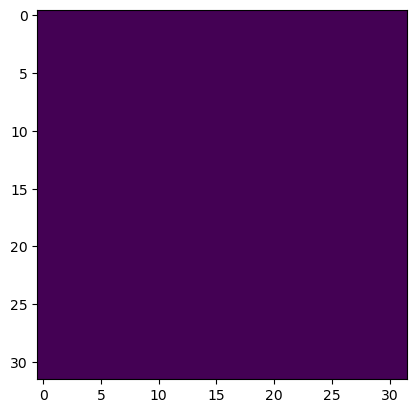

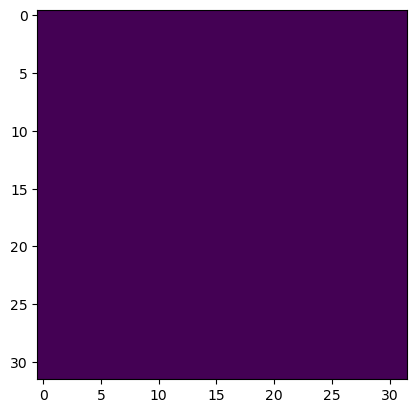

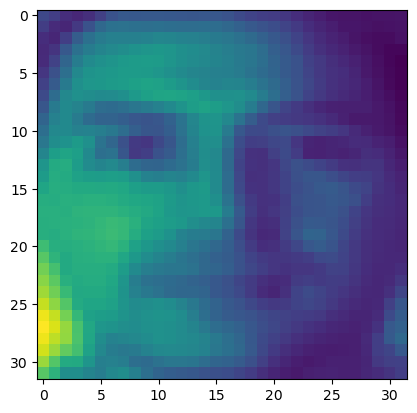

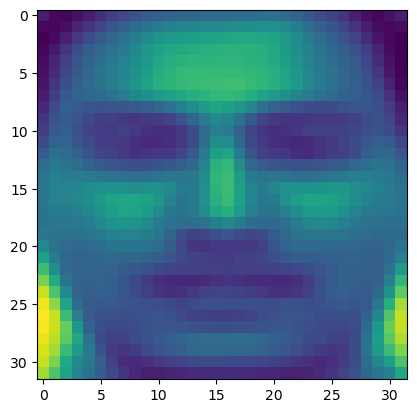

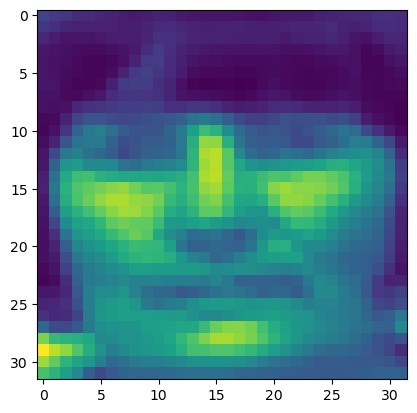

In [34]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def normalize(x):
    """Normalize the input vector x to have unit L2 norm."""
    return x / np.linalg.norm(x)

def spherical_kmeans(data, k, max_iter=100):
    """Perform spherical k-means clustering on the input data."""
    # Initialize cluster centers randomly
    centroids = np.random.randn(k, data.shape[1])
    for i in range(k):
        centroids[i] = normalize(centroids[i])

    for _ in range(max_iter):
        # Assign each data point to the nearest cluster center
        distances = np.dot(data, centroids.T)
        labels = np.argmax(distances, axis=1)

        # Update cluster centers to be the mean of the assigned data points
        for i in range(k):
            mask = (labels == i)
            if np.sum(mask) > 0:
                centroids[i] = normalize(np.mean(data[mask], axis=0))

    return centroids, labels

# set the path to the faces dataset folder
path = r"C:\Users\PC\Desktop\Work"

data = []
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):  # ignore non-directory files
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            try:
                img = Image.open(file_path)
                img = img.resize((32, 32))  # resize the images to 32x32
                img = np.array(img).flatten()  # flatten the images to 1D arrays
                data.append(img)
            except:
                print(f"Error loading file: {file_path}")

data = np.array(data)

# Perform spherical clustering with K=5
centroids, labels = spherical_kmeans(data, k=5)

# Visualize the mean face of each cluster
for i in range(5):
    cluster_data = data[labels == i]
    mean_face = np.mean(cluster_data, axis=0)
    mean_face = mean_face.reshape((32, 32))
    plt.imshow(mean_face.astype(np.uint8))
    plt.show()
